# Predicting Click rates

## You are given models that should predict if a customer will click on an ad as well as corresponding data. For testing purposes the models have all the same interfact and use the numeric data as input. The models are build with XGBoost version 3.0.5.

In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

In [14]:
df = pd.read_csv('click_prediction.csv')

In [15]:
# Use features from the SbA_Upload mapping table
feature_cols = [
    'id', 'year', 'day_of_year', 'time_of_day', 'device_type', 'location', 
    'age', 'browser', 'OS', 'ad_style_category', 
    'part_of_add_evaluation_focus_group', 'provided_feedback_about_add'
] + [f'visited_good_{i}' for i in range(10)] + [f'purchased_good_{i}' for i in range(10)]

X = df[feature_cols]
y_true = df['clicked_on_add']


In [16]:
# 2. Load the JSON models (XGBoost 3.0.5)
model_a = xgb.Booster()
model_a.load_model('add_model_A.json')

In [17]:
model_b = xgb.Booster()
model_b.load_model('add_model_B.json')

In [18]:
dtest = xgb.DMatrix(X)

In [19]:
# 3. Predict probabilities
probs_a = model_a.predict(dtest)
probs_b = model_b.predict(dtest)

In [20]:
# 4. Calibration Curve and ECE
def calculate_ece(y_true, y_prob, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    ece = 0
    for i in range(n_bins):
        # Find samples in the current bin
        in_bin = (y_prob > bin_boundaries[i]) & (y_prob <= bin_boundaries[i+1])
        prop_in_bin = np.mean(in_bin)
        if prop_in_bin > 0:
            accuracy = np.mean(y_true[in_bin])
            confidence = np.mean(y_prob[in_bin])
            ece += prop_in_bin * np.abs(accuracy - confidence)
    return ece

In [21]:
# Calculate values
fop_a, mpv_a = calibration_curve(y, probs_a, n_bins=10)
fop_b, mpv_b = calibration_curve(y, probs_b, n_bins=10)

ece_a = calculate_ece(y, probs_a)
ece_b = calculate_ece(y, probs_b)

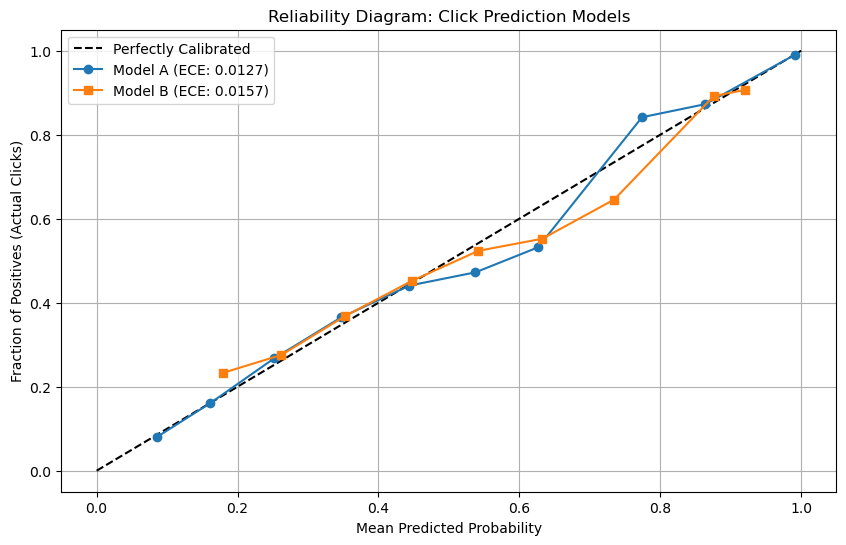

In [22]:
# 5. Visualize Reliability Diagram
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Perfectly Calibrated')
plt.plot(mpv_a, fop_a, marker='o', label=f'Model A (ECE: {ece_a:.4f})')
plt.plot(mpv_b, fop_b, marker='s', label=f'Model B (ECE: {ece_b:.4f})')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Clicks)')
plt.title('Reliability Diagram: Click Prediction Models')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
print(f"Model A Brier Score: {brier_score_loss(y, probs_a):.4f}")
print(f"Model B Brier Score: {brier_score_loss(y, probs_b):.4f}")

Model A Brier Score: 0.1717
Model B Brier Score: 0.2264
